## Imports

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn import preprocessing

import dill

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, SVGD, RBFSteinKernel, Trace_ELBO, NUTS, MCMC
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

import numpy as np

import matplotlib.pyplot as plt

import os

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MCMC Utils

In [7]:
def mean_eff_samples(samples):
    return {k: v.mean(0) for k, v in samples.items()}

## Creating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


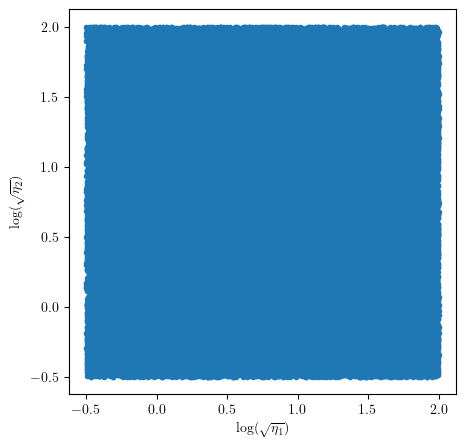

In [8]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Training Parameters

In [9]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "num_layers": 4,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device),
    "device": device,
    "output_prior": torch.tensor([.05], device=device)
}

tree_depth = 15

sampler_params = {
    "warmup_steps": 300,
    "num_samples": 700,
    "num_chains": 3
}

## Defining Data Sets and Scaling

In [10]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaled_test, dtype=torch.float32)
y_test = torch.tensor(y_scaled_test, dtype=torch.float32)

x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

## Training

In [11]:
model = TurbulenceNetworkBayesian(**model_params)

nuts_kernel = NUTS(model, max_tree_depth=tree_depth)
mcmc = MCMC(nuts_kernel, mp_context="spawn", **sampler_params)

mcmc.run(x_train, y_train)
mcmc.summary()

Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1000 [00:00, ?it/s]

/home/codygrogan/.local/lib/python3.12/site-packages/torch/__init__.py:725: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/codygrogan/.local/lib/python3.12/site-packages/torch/__init__.py:725: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/codygrogan/.local/lib/python3.12/site-packages/torch/__init__.py:725: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._s

## Saving MCMC Run

In [19]:
save_name = f"MCMC_model_{sampler_params['num_samples']}_{sampler_params['warmup_steps']}_{tree_depth}_{sampler_params['num_chains']}"
save_MCMC_model(mcmc, "./Model_Checkpoints/NUTS", save_name)


## Loading MCMC Run

In [6]:
save_name = f"MCMC_model_{sampler_params['num_samples']}_{sampler_params['warmup_steps']}_{tree_depth}_{sampler_params['num_chains']}"

model = TurbulenceNetworkBayesian(**model_params)

nuts_kernel = NUTS(model, max_tree_depth=tree_depth)
mcmc = MCMC(nuts_kernel, mp_context="spawn", **sampler_params)

mcmc.run(x_train
model = TurbulenceNetworkBayesian(**model_params)
kernel = NUTS(model, max_tree_depth=tree_depth)

mcmc_test = load_MCMC_model("./Model_Checkpoints/NUTS", save_name, kernel, sampler_params)

print(mcmc_test.summary())

samples = mcmc_test.get_samples()

stem = samples['stem.weight']

param = stem

for i in range(1):
    plt.plot(stem[:, i, 0].cpu().numpy(), label=f"Weight {i}, {0}")

TypeError: TurbulenceNetworkBayesian.__init__() got an unexpected keyword argument 'residual_blocks'

## Plotting Samples

tensor(0.0068, dtype=torch.float64)


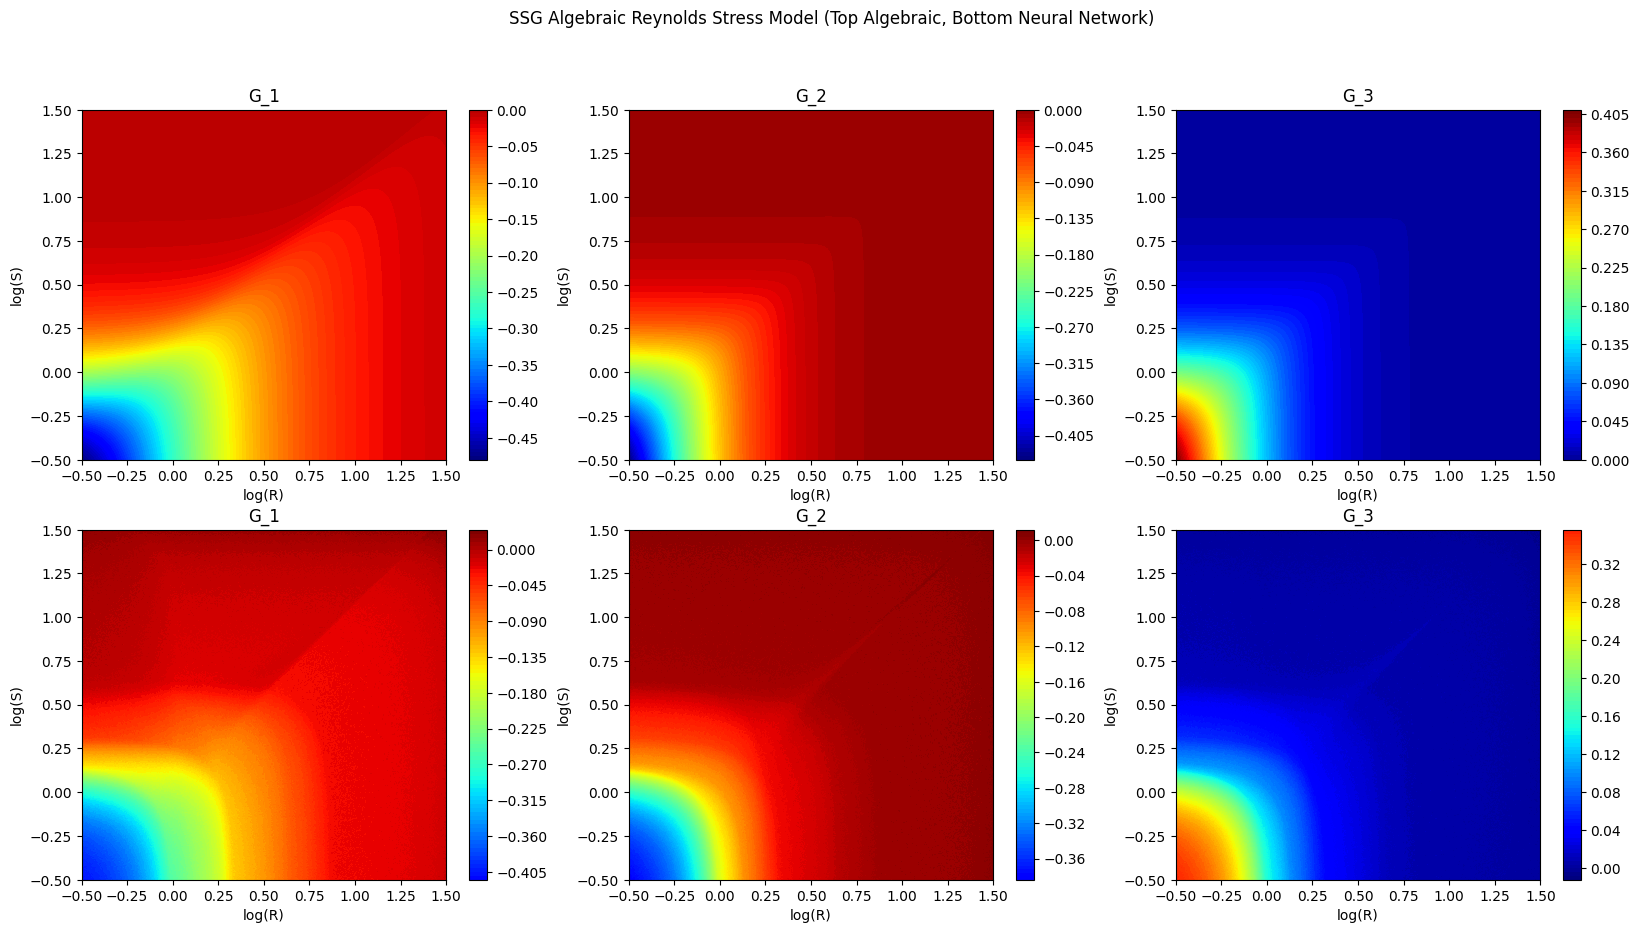

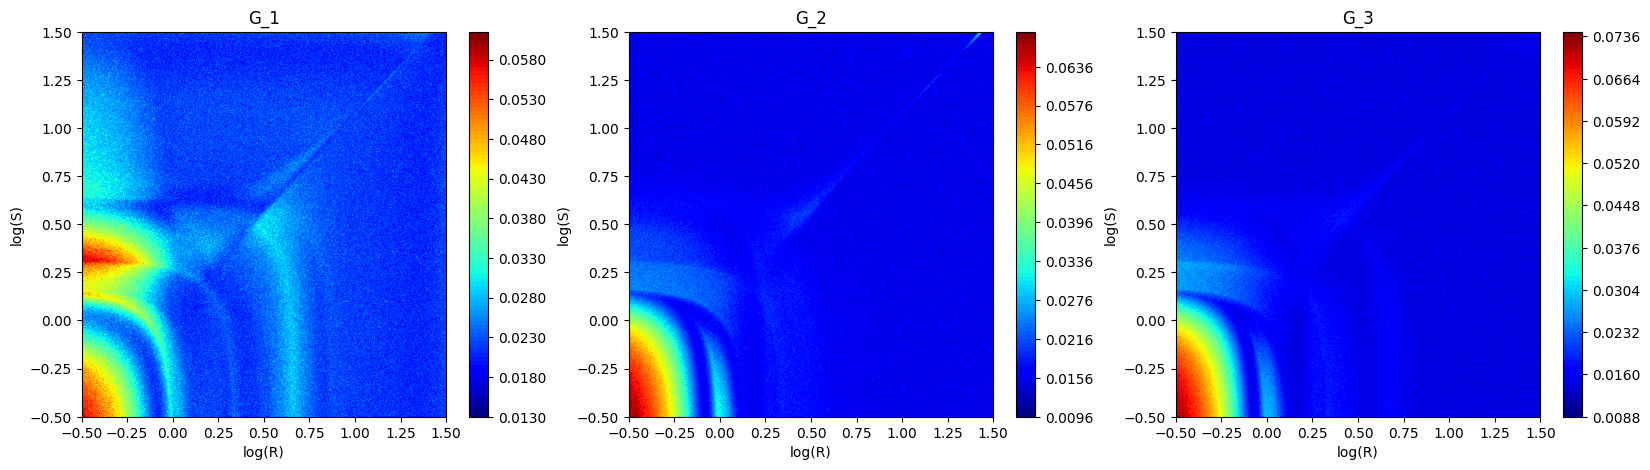

In [7]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

predictive = Predictive(model, posterior_samples=mcmc_test.get_samples(100), return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

for i in range(pred.shape[0]):
    pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

pred_mean = torch.mean(pred, axis=0).detach().cpu().numpy()
pred_std = torch.std(pred, axis=0).detach().cpu().numpy()

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

## Visualizing Samples

### Getting test outputs for each sample

In [8]:
predictive = Predictive(model, posterior_samples=mcmc_test.get_samples(), return_sites=("obs",))

test_preds = predictive(x_test)['obs'].cpu().detach().numpy()
test_preds = test_preds.reshape(test_preds.shape[0], -1)

test_outputs = np.concatenate([test_preds, y_test.cpu().detach().flatten().unsqueeze(0).numpy()], axis=0)

print(test_outputs.shape)

(2101, 1800)


### Visualizing Sample Outputs

Calculating PHATE...
  Running PHATE on 2101 observations and 1800 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.82 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.38 seconds.
    Calculating affinities...
    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 2.42 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.49 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.48 seconds.
  Calculated landmark operator in 5.85 seconds.
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 2.89 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.47 seconds.
Calculated PHATE in 17.98 seconds.


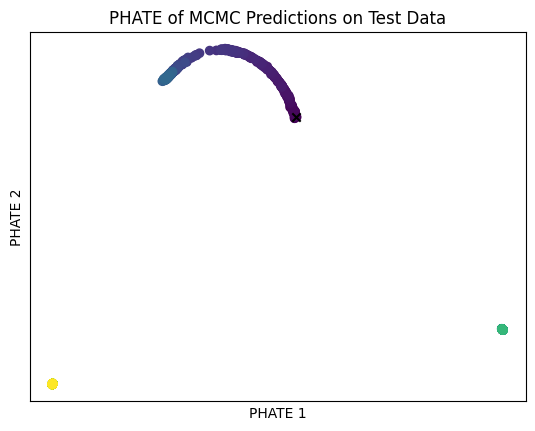

In [9]:
from phate import PHATE

phate_op = PHATE(n_components=2)

phate_outputs = phate_op.fit_transform(test_outputs)

plt.scatter(phate_outputs[0:-1, 0], phate_outputs[0:-1, 1], c=range(test_outputs.shape[0] - 1))

plt.scatter(phate_outputs[-1, 0], phate_outputs[-1, 1], c='black', marker='x')

plt.title("PHATE of MCMC Predictions on Test Data")

plt.xticks([])
plt.yticks([])

plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")

plt.show()